# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for first_layer_W
Gradient check passed!
Checking gradient for second_layer_W
Gradient check passed!
Checking gradient for first_layer_B
Gradient check passed!
Checking gradient for second_layer_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for first_layer_W
Gradient check passed!
Checking gradient for second_layer_W
Gradient check passed!
Checking gradient for first_layer_B
Gradient check passed!
Checking gradient for second_layer_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 39.429963, Train accuracy: 0.337111, val accuracy: 0.343000
Loss: 35.827127, Train accuracy: 0.484222, val accuracy: 0.480000
Loss: 33.971444, Train accuracy: 0.501444, val accuracy: 0.508000
Loss: 41.600215, Train accuracy: 0.531667, val accuracy: 0.529000
Loss: 33.425404, Train accuracy: 0.578778, val accuracy: 0.567000
Loss: 30.350483, Train accuracy: 0.565778, val accuracy: 0.556000
Loss: 30.688578, Train accuracy: 0.575556, val accuracy: 0.560000
Loss: 34.847422, Train accuracy: 0.559333, val accuracy: 0.541000
Loss: 40.182794, Train accuracy: 0.539778, val accuracy: 0.503000
Loss: 34.572445, Train accuracy: 0.549000, val accuracy: 0.541000
Loss: 42.455496, Train accuracy: 0.547667, val accuracy: 0.547000
Loss: 36.038165, Train accuracy: 0.598667, val accuracy: 0.586000
Loss: 35.557434, Train accuracy: 0.530000, val accuracy: 0.503000
Loss: 38.396311, Train accuracy: 0.594444, val accuracy: 0.581000
Loss: 38.266815, Train accuracy: 0.598444, val accuracy: 0.612000
Loss: 40.6

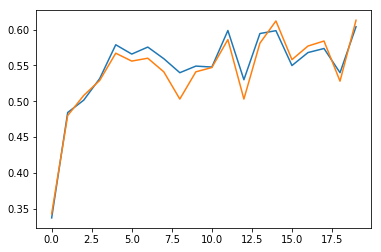

In [10]:
plt.plot(train_history)
plt.plot(val_history)
plt.show()

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

Loss: 41.434652, Train accuracy: 0.324889, val accuracy: 0.341000
Loss: 43.098394, Train accuracy: 0.533778, val accuracy: 0.538000
Loss: 49.653042, Train accuracy: 0.477222, val accuracy: 0.470000
Loss: 31.086640, Train accuracy: 0.593778, val accuracy: 0.590000
Loss: 34.675877, Train accuracy: 0.575000, val accuracy: 0.569000
Loss: 51.776259, Train accuracy: 0.492556, val accuracy: 0.489000
Loss: 34.991629, Train accuracy: 0.589111, val accuracy: 0.606000
Loss: 35.295137, Train accuracy: 0.592444, val accuracy: 0.576000
Loss: 41.000906, Train accuracy: 0.599778, val accuracy: 0.595000
Loss: 34.309963, Train accuracy: 0.614111, val accuracy: 0.594000
Loss: 34.084474, Train accuracy: 0.532889, val accuracy: 0.551000
Loss: 30.093477, Train accuracy: 0.669111, val accuracy: 0.657000
Loss: 50.203479, Train accuracy: 0.564000, val accuracy: 0.545000
Loss: 36.393499, Train accuracy: 0.591667, val accuracy: 0.585000
Loss: 40.909470, Train accuracy: 0.610222, val accuracy: 0.605000
Loss: 36.5

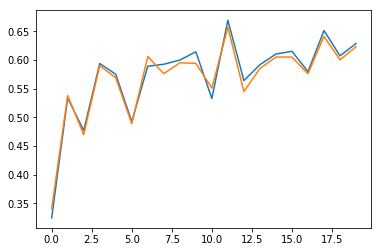

In [11]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

plt.plot(train_history)
plt.plot(val_history)
plt.show()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

Loss: 44.724276, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 43.431613, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.521125, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 39.192398, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 40.442832, Train accuracy: 0.207444, val accuracy: 0.215000
Loss: 44.966102, Train accuracy: 0.254556, val accuracy: 0.258000
Loss: 36.099310, Train accuracy: 0.278444, val accuracy: 0.280000
Loss: 39.787739, Train accuracy: 0.305222, val accuracy: 0.314000
Loss: 37.015723, Train accuracy: 0.353333, val accuracy: 0.349000
Loss: 37.193913, Train accuracy: 0.397889, val accuracy: 0.394000
Loss: 33.648729, Train accuracy: 0.432556, val accuracy: 0.424000
Loss: 33.812997, Train accuracy: 0.464778, val accuracy: 0.450000
Loss: 26.709668, Train accuracy: 0.495556, val accuracy: 0.479000
Loss: 31.556996, Train accuracy: 0.525778, val accuracy: 0.521000
Loss: 35.514641, Train accuracy: 0.550556, val accuracy: 0.544000
Loss: 32.5

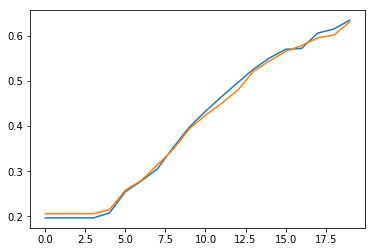

In [12]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

plt.plot(train_history)
plt.plot(val_history)
plt.show()

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [13]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 11.595793, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.519891, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.456435, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.588794, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 11.498183, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 11.544711, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 11.356434, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.246958, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.356238, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.224228, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.970904, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.368312, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.738058, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.135872, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 10.527746, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.4

Loss: 1.899079, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.792973, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.070367, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.104899, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.927898, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.425543, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.092371, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.750161, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.408080, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.075315, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.973584, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.372063, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.204994, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.192922, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.017100, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.047606, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [16]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

hidden_layer_sizes = list(range(50, 101, 10))
regularization_pars = [1e-1, 1e-2, 1e-3]
learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
batch_sizes = [3, 5, 10, 15]

best_pars = [hidden_layer_sizes[0], regularization_pars[0], learning_rates[0], batch_sizes[0]]
best_acc = 0

for lr in learning_rates:
    for _ in range(10):
        reg = np.random.choice(regularization_pars)
        hls = np.random.choice(hidden_layer_sizes)
        bs = np.random.choice(batch_sizes)
        model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hls, reg = reg)
        dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
        # TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
        trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=lr, num_epochs=20, batch_size=bs)
        
        loss_history, train_history, val_history = trainer.fit()
        if train_history[-1] > best_acc:
            best_acc = train_history[-1]
            best_pars = [hls, reg, lr, bs]

print(best_acc, best_pars)

Loss: nan, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: nan, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: nan, Train accuracy: 0.066667, val accuracy: 0.200000
Loss: nan, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: nan, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: nan, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.200000
Loss: nan, Train accuracy: 0.200000, val accuracy: 0.200000
Loss: nan, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: nan, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.266667, val

Loss: nan, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.200000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.266667
Loss: nan, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.200000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.266667
Loss: 14.796189, Train accuracy: 0.000000, val accuracy: 0.266667
Loss: nan, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: nan, Train accuracy: 0.13333

Loss: nan, Train accuracy: 0.266667, val accuracy: 0.200000
Loss: nan, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.266667, val accuracy: 0.200000
Loss: nan, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: nan, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: nan, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: nan, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: nan, Train accuracy: 0.200000, val accuracy: 0.200000
Loss: nan, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: nan, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: nan, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 11.530972, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.417488, Train accuracy: 0

Loss: 10.907455, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 7.996199, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.496130, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 10.841995, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 7.118202, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 6.400336, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 6.662545, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 8.464963, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 4.455379, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 2.721879, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 1.131078, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 5.522818, Train accuracy: 0.800000, val accuracy: 0.066667
Loss: 4.473586, Train accuracy: 0.866667, val accuracy: 0.000000
Loss: 1.093001, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 11.503783, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 11.505637, Trai

Loss: 3.126248, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.747489, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 0.330844, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.649736, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.390328, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 6.885142, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 6.858669, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 6.509489, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 6.794409, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 6.567853, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 7.349063, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 5.602102, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 6.005757, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 6.751503, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.780576, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.978759, Train acc

Loss: 11.516697, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.521499, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.494048, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.466431, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.435977, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.470385, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.378080, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.251424, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 11.320838, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 11.087955, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 11.399745, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 11.306219, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 11.091426, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.255560, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 10.740686, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.7

Loss: 11.454900, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.510341, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.499648, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.508604, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.464964, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.465279, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.477974, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.444921, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 34.531096, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 34.530229, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 34.528584, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 34.526238, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 34.523263, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 34.519724, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 34.515679, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 34.5

Loss: 34.543162, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 34.542296, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 34.540651, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 34.538306, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 34.535332, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 34.531793, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 34.527748, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 34.523250, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 34.518346, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 34.513078, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 34.507486, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 34.501604, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 34.495463, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 34.489092, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 34.482516, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 34.4

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [23]:
# Let's train the best one-hidden-layer network we can

learning_rate_decay = 0.999
num_epochs = 20
batch_size = 64

hidden_layer_sizes = list(range(50, 121, 10))
reg_str = [1e-2, 1e-3, 1e-4]
learning_rates = [1e-2, 1e-3, 1e-4]

best_classifier = None
best_val_accuracy = 0

for lr in learning_rates:
    for _ in range(10):
        reg = np.random.choice(reg_str)
        hls = np.random.choice(hidden_layer_sizes)
        
        model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=hls, reg=reg)
        dataset = Dataset(train_X, train_y, val_X, val_y)
        trainer = Trainer(model, dataset, MomentumSGD(), learning_rate_decay=learning_rate_decay, \
                          learning_rate=lr, num_epochs=num_epochs, batch_size=batch_size)
        
        loss_history, train_history, val_history = trainer.fit()
        if val_history[-1] > best_val_accuracy:
            best_val_accuracy = val_history[-1]
            best_classifier = model

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: nan, Train accuracy: 0.123333, val accuracy: 0.137000
Loss: nan, Train accuracy: 0.076667, val accuracy: 0.067000
Loss: nan, Train accuracy: 0.121889, val accuracy: 0.141000
Loss: nan, Train accuracy: 0.097444, val accuracy: 0.118000
Loss: nan, Train accuracy: 0.118222, val accuracy: 0.127000
Loss: nan, Train accuracy: 0.141444, val accuracy: 0.142000
Loss: nan, Train accuracy: 0.139444, val accuracy: 0.140000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val

Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.070778, val accuracy: 0.071000
Loss: nan, Train accuracy: 0.085111, val accuracy: 0.074000
Loss: nan, Train accuracy: 0.093556, val accuracy: 0.087000
Loss: nan, Train accuracy: 0.175333, val accuracy: 0.177000
Loss: nan, Train accuracy: 0.130222, val accuracy: 0.138000
Loss: nan, Train accuracy: 0.142667, val accuracy: 0.162000
Loss: nan, Train accuracy: 0.118556, val accuracy: 0.107000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val

Loss: 41.741058, Train accuracy: 0.721000, val accuracy: 0.662000
Loss: 31.419463, Train accuracy: 0.778778, val accuracy: 0.714000
Loss: 37.532197, Train accuracy: 0.718222, val accuracy: 0.647000
Loss: 39.564216, Train accuracy: 0.758667, val accuracy: 0.687000
Loss: 27.507987, Train accuracy: 0.774889, val accuracy: 0.704000
Loss: 32.180625, Train accuracy: 0.804667, val accuracy: 0.710000
Loss: 37.174811, Train accuracy: 0.779444, val accuracy: 0.691000
Loss: 32.621082, Train accuracy: 0.778000, val accuracy: 0.683000
Loss: 52.869973, Train accuracy: 0.803333, val accuracy: 0.697000
Loss: 41.288750, Train accuracy: 0.794222, val accuracy: 0.706000
Loss: 36.703876, Train accuracy: 0.825556, val accuracy: 0.704000
Loss: 43.906891, Train accuracy: 0.795556, val accuracy: 0.703000
Loss: 39.836376, Train accuracy: 0.790333, val accuracy: 0.697000
Loss: 76.577394, Train accuracy: 0.240778, val accuracy: 0.235000
Loss: 58.177644, Train accuracy: 0.484889, val accuracy: 0.456000
Loss: 56.8

Loss: 33.937699, Train accuracy: 0.749889, val accuracy: 0.668000
Loss: 24.127204, Train accuracy: 0.816667, val accuracy: 0.718000
Loss: 54.789030, Train accuracy: 0.796444, val accuracy: 0.706000
Loss: 34.528934, Train accuracy: 0.816222, val accuracy: 0.736000
Loss: 55.930128, Train accuracy: 0.814444, val accuracy: 0.710000
Loss: 24.466490, Train accuracy: 0.839778, val accuracy: 0.741000
Loss: 21.468268, Train accuracy: 0.841111, val accuracy: 0.716000
Loss: 29.708782, Train accuracy: 0.844444, val accuracy: 0.722000
Loss: 85.734187, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.671924, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 86.939617, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 83.328636, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.917233, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 82.287640, Train accuracy: 0.246778, val accuracy: 0.249000
Loss: 80.178812, Train accuracy: 0.281889, val accuracy: 0.288000
Loss: 85.2

Loss: 41.267894, Train accuracy: 0.673889, val accuracy: 0.638000
Loss: 38.169245, Train accuracy: 0.688889, val accuracy: 0.664000
Loss: 43.149445, Train accuracy: 0.693778, val accuracy: 0.673000
Loss: 87.148550, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.384974, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.124519, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 90.405850, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.753106, Train accuracy: 0.212222, val accuracy: 0.217000
Loss: 85.428386, Train accuracy: 0.261444, val accuracy: 0.267000
Loss: 76.502056, Train accuracy: 0.280889, val accuracy: 0.281000
Loss: 68.407653, Train accuracy: 0.345222, val accuracy: 0.348000
Loss: 67.616053, Train accuracy: 0.419000, val accuracy: 0.414000
Loss: 64.309900, Train accuracy: 0.465333, val accuracy: 0.456000
Loss: 67.994350, Train accuracy: 0.504556, val accuracy: 0.497000
Loss: 61.407921, Train accuracy: 0.538333, val accuracy: 0.525000
Loss: 61.4

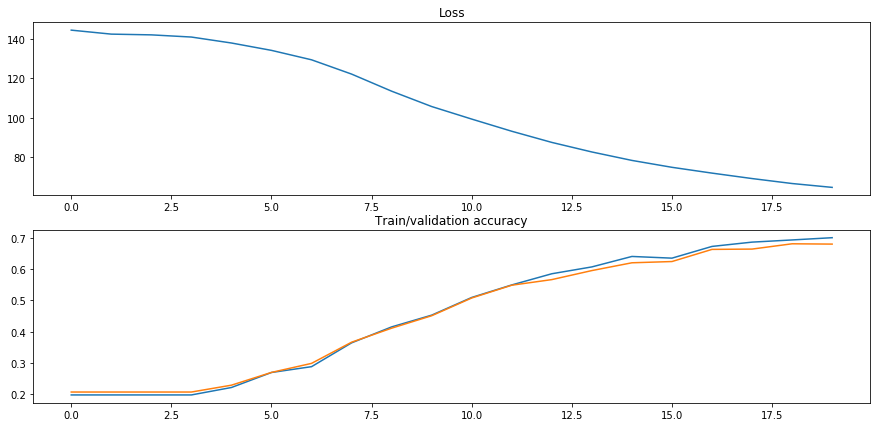

In [24]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [25]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.699000
